In [199]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# load general packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
from educationmodel_3_Lise_1 import EducationModel
import estimate_1 as est 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [200]:
model = EducationModel()

In [201]:
model.solve()

In [202]:
sol = model.sol

In [203]:
sol.d.min()

6.818995858896062e-87

In [204]:
par = model.par 
sol= model.sol

In [205]:
est = est.estimate_class()
family_data, decision_data = est.read_data()

In [206]:
# spørgsmålet er, hvad vi gør, når vi propper nan ind og prøver at interpolere på den. Det tænker jeg jo lidt er noget lort. 
decision_data_5 = decision_data[decision_data['id'] == 1709]
decision_data_5

,id,year,dummy_school,edu_going_in,dummy_interrup,dummy_work,exp_going_in,wage
1708,1709,1980,0,12,0,1,1.00,NaN
3418,1709,1981,0,12,0,1,2.00,NaN
5128,1709,1982,0,12,1,0,3.00,NaN
6838,1709,1983,0,12,1,0,NaN,NaN
8548,1709,1984,0,12,1,0,4.09,NaN
10258,1709,1985,0,12,1,0,NaN,NaN
11968,1709,1986,0,12,1,0,NaN,NaN
13678,1709,1987,0,12,1,0,NaN,NaN
15388,1709,1988,0,12,1,0,NaN,NaN
17098,1709,1989,0,12,1,0,NaN,NaN


In [207]:
decision_data_7 = decision_data[decision_data['id'] == 7]
decision_data_7

,id,year,dummy_school,edu_going_in,dummy_interrup,dummy_work,exp_going_in,wage
6,7,1980,1,11,0,0,0.0,NaN
1716,7,1981,1,12,0,0,0.0,NaN
3426,7,1982,1,13,0,0,0.0,NaN
5136,7,1983,0,14,1,0,0.0,8.53
6846,7,1984,0,14,1,0,0.0,NaN
8556,7,1985,0,14,1,0,0.0,NaN
10266,7,1986,1,14,0,0,0.0,NaN
11976,7,1987,1,15,0,0,0.0,NaN
13686,7,1988,0,16,0,1,0.0,NaN
15396,7,1989,0,16,0,1,1.0,NaN


In [208]:
decision_data_1 = decision_data[decision_data['id'] == 1]
decision_data_1

,id,year,dummy_school,edu_going_in,dummy_interrup,dummy_work,exp_going_in,wage
0,1,1980,1,13,0,0,0.00,NaN
1710,1,1981,1,14,0,0,0.00,NaN
3420,1,1982,1,15,0,0,0.00,NaN
5130,1,1983,0,16,0,1,0.00,4.40
6840,1,1984,0,16,0,1,0.58,8.70
8550,1,1985,0,16,0,1,1.33,9.34
10260,1,1986,0,16,0,1,2.33,10.32
11970,1,1987,0,16,0,1,3.33,10.94
13680,1,1988,0,16,0,1,4.33,11.68
15390,1,1989,0,16,0,1,5.33,11.83


In [209]:
from consav.linear_interp import interp_4d

In [210]:
# give ability
Dad_educ = family_data.Dad_educ
Mom_educ = family_data.Mom_educ
Family_income = family_data.Family_income
Num_siblings = family_data.Num_siblings
Nuclear = family_data.Nuclear
Urban = family_data.Urban
South = family_data.South


experience = decision_data.exp 
school_time = decision_data.edu


d = decision_data.dummy

util_school  = par.delta0*Dad_educ + par.delta1*Mom_educ + par.delta2*Family_income + par.delta3*Num_siblings + par.delta4*Nuclear + par.delta5*Urban + par.delta6*South
ability_wage = par.gamma0_w*Dad_educ + par.gamma1_w*Mom_educ + par.gamma2_w*Family_income + par.gamma3_w*Num_siblings + par.gamma4_w*Nuclear + par.gamma5_w*Urban + par.gamma6_w*South
ability_employment = par.gamma0_e*Dad_educ + par.gamma1_e*Mom_educ + par.gamma2_e*Family_income + par.gamma3_e*Num_siblings + par.gamma4_e*Nuclear + par.gamma5_e*Urban + par.gamma6_e*South
# ability_wage
# ability_employment

school_time_index =school_time-6

# probability of staying in school given the state
# AND THE ORTHOGONAL TYPE
log_likelihood = 0

epsilon = 1e-10

probabilities = {0: par.p1, 1: par.p2, 2: par.p3, 3: par.p4, 4: par.p5, 5: par.p6}
# Iterate over N and T
for i in range(par.N):
    for t in range(par.T):
        # Iterate through all choices including 0
        for x in range(1, 6):

            experience_i = experience[i + par.N * t]
            for i in range(t):
                #if experience_i equal to nan 
                if np.isnan(experience_i):
                    print('experience_i is nan')
                    experience_i = experience[i + par.N *(t-1)]
            
            if np.isnan(experience_i):
                print('experience_i is still nan')
                experience_i = 0

            sol_x = sol.d[t, x, :, :, :, school_time_index[i + par.N * t], :]
            lik_pr_x = interp_4d(
                par.nuw_fix_grid,
                par.nue_fix_grid,
                par.util_sch_fix_grid,
                par.experience_grid,
                sol_x,
                ability_wage[i],
                ability_employment[i],
                util_school[i],
                experience_i
            )
            clamped_lik_pr_x = np.clip(lik_pr_x, epsilon, 1-epsilon)

            if np.isnan(clamped_lik_pr_x).any() or np.isinf(clamped_lik_pr_x).any():
                print(f'NaN or Inf encountered at i={i}, t={t}, x={x}')
                print(f'clamped_lik_pr_x: {clamped_lik_pr_x}')
                print(f'choice_prob_x: {choice_prob_x}')
                clamped_lik_pr_x = 0.1
                continue

            choice_prob_x = clamped_lik_pr_x * d[i + par.N * t] + (1 - clamped_lik_pr_x) * (1 - d[i + par.N * t])
            #if choice_prob_x < 0:
            #    print('choice_prob_x <= 0, i, t:', i, t)
            #    print('choice_prob_x:', choice_prob_x)
            #    log_likelihood += -np.inf
            #else:

            if np.isnan(choice_prob_x).any() or np.isinf(choice_prob_x).any():
                print(f'NaN or Inf encountered at i={i}, t={t}, x={x}')
                print(f'clamped_lik_pr_x: {clamped_lik_pr_x}')
                print(f'choice_prob_x: {choice_prob_x}')
                continue

            if x in probabilities:
                log_likelihood += probabilities[x] * np.log(choice_prob_x)
            #print('log_likelihood =', log_likelihood)

print('log_likelihood =', log_likelihood)


AttributeError: 'DataFrame' object has no attribute 'exp'

In [ ]:
sol.d.mean()

0.4156069665372946

In [ ]:
sol.d[0,5,14,:]

IndexError: index 5 is out of bounds for axis 1 with size 4

In [ ]:
sol.d

array([[[[[[9.14303449e-001, 9.17689501e-001, 9.20514459e-001, ...,
            9.29654604e-001, 9.29676898e-001, 9.29681814e-001],
           [9.66471778e-001, 9.67891923e-001, 9.69068426e-001, ...,
            9.72794587e-001, 9.72803008e-001, 9.72804701e-001],
           [9.87545819e-001, 9.88085585e-001, 9.88531331e-001, ...,
            9.89926589e-001, 9.89929551e-001, 9.89930085e-001],
           ...,
           [9.99999528e-001, 9.99999548e-001, 9.99999564e-001, ...,
            9.99999611e-001, 9.99999612e-001, 9.99999612e-001],
           [9.99999829e-001, 9.99999836e-001, 9.99999842e-001, ...,
            9.99999859e-001, 9.99999859e-001, 9.99999859e-001],
           [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
            1.00000000e+000, 1.00000000e+000, 1.00000000e+000]],

          [[1.01120113e-004, 1.08153234e-004, 1.15085846e-004, ...,
            1.68972964e-004, 1.69108143e-004, 1.69109477e-004],
           [2.05985116e-004, 2.19164310e-004, 2.32085959e-

## Estimate

In [ ]:
par = model.par

In [ ]:
family_data, decision_data = est.read_data()

In [ ]:
Dad_educ = family_data.Dad_educ
Mom_educ = family_data.Mom_educ
Family_income = family_data.Family_income
Num_siblings = family_data.Num_siblings
Nuclear = family_data.Nuclear
Urban = family_data.Urban
South = family_data.South


experience = decision_data.exp 
school_time = decision_data.edu


d = decision_data.dummy

util_school  = par.delta0*Dad_educ + par.delta1*Mom_educ + par.delta2*Family_income + par.delta3*Num_siblings + par.delta4*Nuclear + par.delta5*Urban + par.delta6*South
ability_wage = par.gamma0_w*Dad_educ + par.gamma1_w*Mom_educ + par.gamma2_w*Family_income + par.gamma3_w*Num_siblings + par.gamma4_w*Nuclear + par.gamma5_w*Urban + par.gamma6_w*South
#ability_employment = par.gamma0_e*Dad_educ + par.gamma1_e*Mom_educ + par.gamma2_e*Family_income + par.gamma3_e*Num_siblings + par.gamma4_e*Nuclear + par.gamma5_e*Urban + par.gamma6_e*South

In [ ]:
print(f'Max util_school: {util_school.max()}, Min util_school: {util_school.min()}')
print(f'Max ability_wage: {ability_wage.max()}, Min ability_wage: {ability_wage.min()}')
#print(f'Max ability_employment: {ability_employment.max()}, Min ability_employment: {ability_employment.min()}')


Max util_school: 255.82457, Min util_school: 0.0489
Max ability_wage: 180.39482, Min ability_wage: -0.121


In [ ]:
delta7= np.linspace(-5,5,5)
log_lik = np.nan + np.zeros(5)

In [ ]:
# Problemet er her, at vi rammer noget negativt. 
for i in range(5):
    pnames = ['delta7']
    theta = np.array([delta7[i]])
    log_lik[i]=est.ll(theta,model, family_data, decision_data, pnames)

delta7 -5.0
model solved


/Users/astridblixmogensen/OneDrive - University of Copenhagen/Dokumenter/Økonomi/9. semester/Dynamic programming/Term paper/Dynamic-Programming/estimate_1.py:108: RuntimeWarning: invalid value encountered in log
  


log_likelihood = nan
delta7 -2.5
model solved


/Users/astridblixmogensen/OneDrive - University of Copenhagen/Dokumenter/Økonomi/9. semester/Dynamic programming/Term paper/Dynamic-Programming/estimate_1.py:108: RuntimeWarning: invalid value encountered in log
  


log_likelihood = nan
delta7 0.0
model solved


/Users/astridblixmogensen/OneDrive - University of Copenhagen/Dokumenter/Økonomi/9. semester/Dynamic programming/Term paper/Dynamic-Programming/estimate_1.py:108: RuntimeWarning: invalid value encountered in log
  


log_likelihood = nan
delta7 2.5
model solved


/Users/astridblixmogensen/OneDrive - University of Copenhagen/Dokumenter/Økonomi/9. semester/Dynamic programming/Term paper/Dynamic-Programming/estimate_1.py:108: RuntimeWarning: invalid value encountered in log
  


log_likelihood = nan
delta7 5.0
model solved


/Users/astridblixmogensen/OneDrive - University of Copenhagen/Dokumenter/Økonomi/9. semester/Dynamic programming/Term paper/Dynamic-Programming/estimate_1.py:108: RuntimeWarning: invalid value encountered in log
  


log_likelihood = nan


In [ ]:
delta7

array([-5. , -2.5,  0. ,  2.5,  5. ])

In [ ]:
log_lik

array([nan, nan, nan, nan, nan])

In [ ]:
log_lik

array([-147047.5801673, -147047.5801673, -147047.5801673, -147047.5801673,
       -147047.5801673])

In [ ]:
pnames = ['delta7']

In [ ]:
model = est.updatepar(model,pnames,theta)

In [ ]:
def updatepar(par,parnames, parvals):
    """ Update parameters """
    for i,parname in enumerate(parnames):
        parval = parvals[i]
        setattr(par,parname,parval)
    return par

In [ ]:
par = model.par

In [ ]:
updatepar(model.par, pnames, [7])

namespace(T=11,
          simT=11,
          beta=0.97,
          Nfix=6,
          simN=300,
          N=1710,
          delta0=0.1,
          delta1=0.2,
          delta2=0,
          delta3=0.3,
          delta4=0,
          delta5=0,
          delta6=0,
          gamma0_w=0,
          gamma1_w=0,
          gamma2_w=0.5,
          gamma3_w=0,
          gamma4_w=0,
          gamma5_w=0,
          gamma6_w=0,
          gamma0_e=0,
          gamma1_e=0,
          gamma2_e=0,
          gamma3_e=0,
          gamma4_e=0.6,
          gamma5_e=0,
          gamma6_e=0,
          delta7=7,
          kappa1=-0.0258,
          kappa2=-0.0146,
          kappa3=0.0001,
          phi2=0.0877,
          phi3=-0.003,
          phi1=1,
          school_time_min=6,
          school_time_max=20,
          Nst=15,
          experience_min=0,
          experience_max=17,
          Ne=18,
          zeta=0.0749,
          nuxi_tilde_1=-2.9693,
          nuxi_tilde_2=-2.7838,
          nuxi_tilde_3=-3.2766,

In [ ]:
par.delta7

7

In [ ]:
model.par.delta7

-1e-05

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


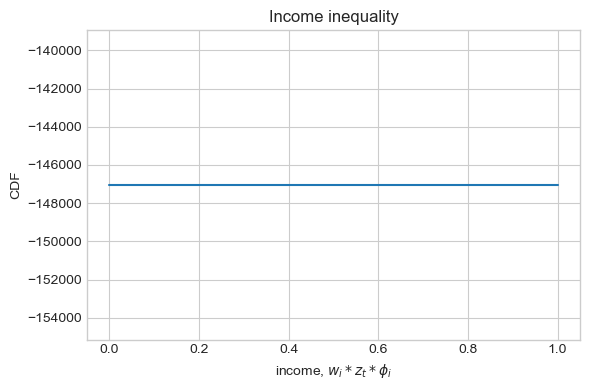

In [ ]:
fig = plt.figure(figsize=(6,4),dpi=100)

ax = fig.add_subplot(1,1,1)
ax.set_title('Income inequality')

ax.plot(delta7,log_lik)

ax.set_xlabel('delta7')
ax.set_ylabel('log likelihood')
ax.legend()


fig.tight_layout()

## Simulate

In [211]:
model.simulate_2()
sim=model.sim

hejsa


In [212]:
Type1 = np.where((sim.util_school_fix == 50) & (sim.abil_job_fix == 30),1,0)
Type2 = np.where((sim.util_school_fix == 200) & (sim.abil_job_fix == 30),1,0)
Type3 = np.where((sim.util_school_fix == 50) & (sim.abil_job_fix == 120),1,0)
Type4 = np.where((sim.util_school_fix == 200) & (sim.abil_job_fix == 120),1,0)


In [213]:
mean_school_vectors =[]
mean_interrupt_vectors =[]
mean_school_time_vectors = []
mean_wage_vectors = []
mean_experience_vectors = []

In [214]:
types = [Type1,Type2,Type3,Type4]
for s in types:
    i = np.where(s == 1)[0]

    mean_school = sim.school[i].mean(axis=0)
    mean_interrupt = sim.interrupt[i].mean(axis=0)
    mean_school_time = sim.school_time[i].mean(axis=0)
    mean_wage = np.nanmean(sim.wage[i],axis=0)
    mean_experience = np.nanmean(sim.experience[i],axis=0)
    mean_school_vectors.append(mean_school)
    mean_interrupt_vectors.append(mean_interrupt)
    mean_school_time_vectors.append(mean_school_time)
    mean_wage_vectors.append(mean_wage)
    mean_experience_vectors.append(mean_experience)


/var/folders/0d/9fxwhbm96fddwvy2wk2rxltc0000gn/T/ipykernel_11442/3719368034.py:8: RuntimeWarning: Mean of empty slice
  mean_wage = np.nanmean(sim.wage[i],axis=0)


In [215]:
mean_wage_vectors

[array([ 172.91801553,  212.21964949,  571.70925271,  655.36170809,
         910.62254454, 1102.97497865, 1757.95804642, 2794.1487944 ,
        4893.70606033, 5769.43180879]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([ 86.5702198 , 103.37126357, 103.30136411, 116.99006567,
        128.77472457, 143.63730535, 145.13414281, 152.42211889,
        159.99012491, 157.32333809]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])]

In [216]:
plot_vectors = [mean_school_vectors, mean_interrupt_vectors, mean_school_time_vectors, mean_wage_vectors, mean_experience_vectors]
vector_names = ["Mean schooling choice","Mean interruption choice", "Mean school time", "Mean wage", "Mean experience"]

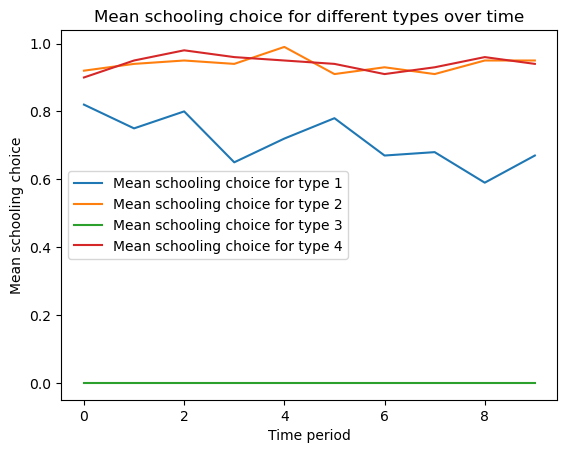

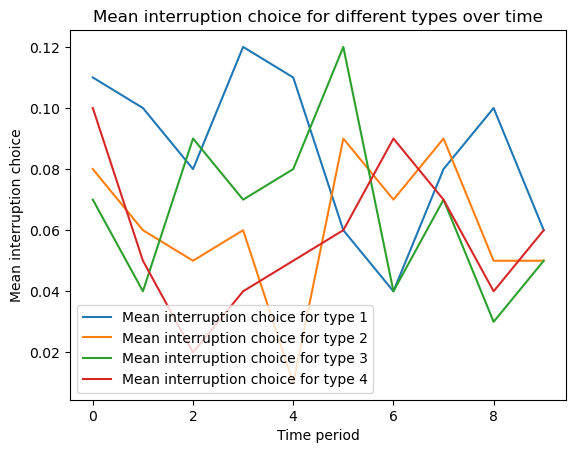

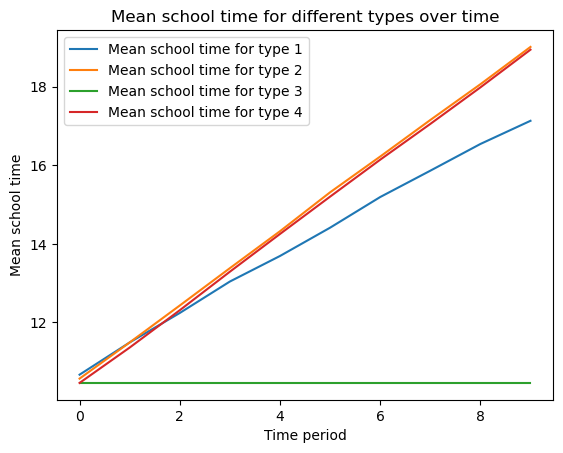

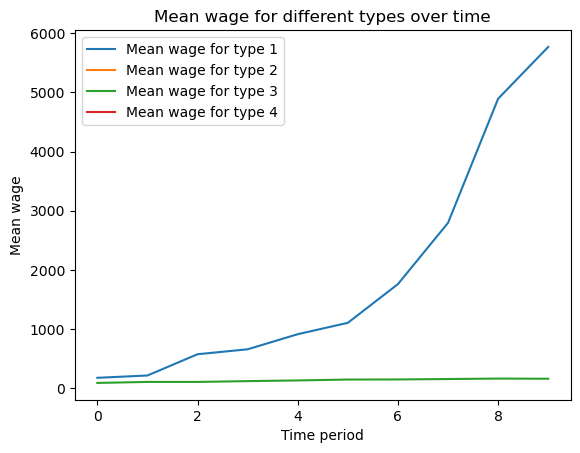

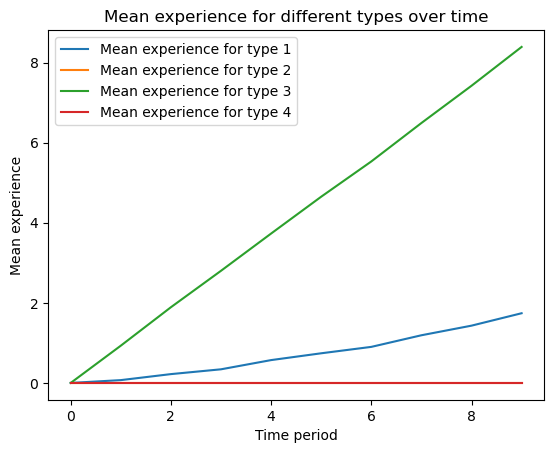

In [217]:
for vector, name in zip(plot_vectors, vector_names):
    for i in range(4):
        plt.plot(vector[i], label=f"{name} for type {i+1}")
    plt.legend()
    plt.xlabel("Time period")
    plt.ylabel(name)
    plt.title(f"{name} for different types over time")
    plt.show()

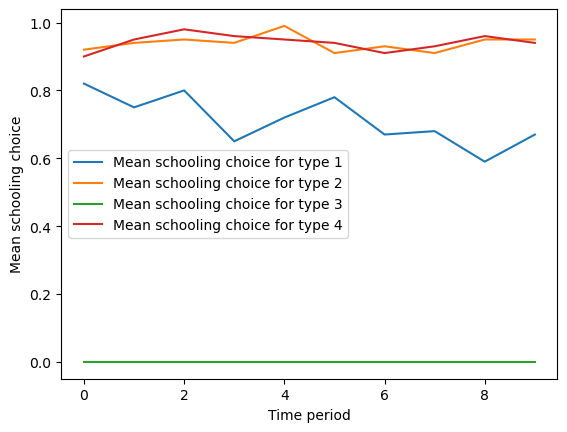

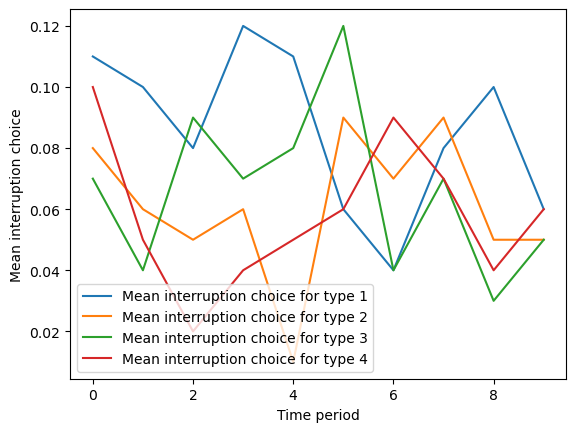

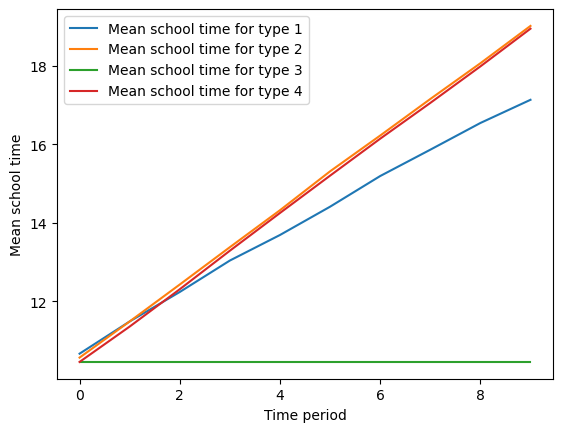

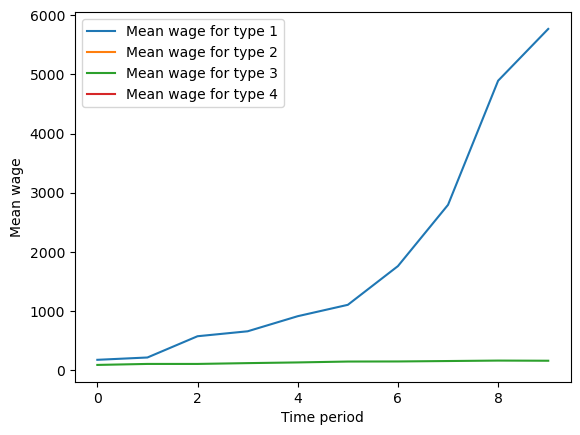

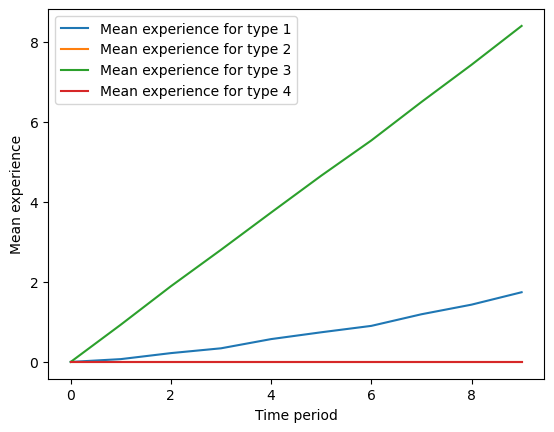

In [218]:
for vector, name in zip(plot_vectors, vector_names):
    for i in range(4):
        plt.plot(vector[i], label=f"{name} for type {i+1}")
    plt.legend()
    plt.xlabel("Time period")
    plt.ylabel(name)
    #plt.title(f"{name} for different types over time")
    # Save the figure with a unique filename
    plt.savefig(f"{name}_for_type_{i+1}_over_time.png")
    # Show the figure
    plt.show()
